Notes: Change diagram number of qubits
Update Eigenvalue Rotation derivation

<div style="font-family: 'Times New Roman'; font-size: 16px;">

# Quantum Linear Algebra
The Harrow–Hassidim–Lloyd (HHL) algorithm [Project 1]  
*By Sonny Lowe, David Lee, Arav Raval*

</div>


<div style="font-family: 'Times New Roman'; font-size: 16px;">

This notebook will discuss the Harrow-Hassidim-Lloyd (HHL) quantum algorithm, meant for solving a linear system
$$A\vec{x}=\vec{b} \text{ ,  where } A \text{ is a hermitian matrix}$$
and where $\vec{x}$ and $\vec{b}$ ultimately represent quantum states $\ket{x}$ and $\ket{b}$ respectively. We will provide a derivation, implementation, generalization to non-hermitian matrices, as well as the context for HHL as a subroutine.

Note: we will generally be working in the normalized domain.
</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 1: Mathematical Derivation
 
Our problem is represented as 
$$A\ket{x} = \ket{b}$$
where $\ket{b} \in \mathbb{C}^N$ is some given quantum state and $A \in \mathbb{C}^{N\times N}$. Our goal is to solve for $\ket{x} \in \mathbb{C}^N$ under a few conditions:
- $A$ is hermitian such that $A = A^\dagger$
- $A$ is $s$-sparse and well conditioned, meaning it has at most $s$ nonzero entries per row and its condition number  $\kappa(A)$ is relatively small such that the system is stable and less sensitive to perturbations.
We will break down the derivation into several steps.
- We have access to an "oracle" of A in that we have its eigenvalues to use in our circuit (potential weakness).
- We assume there exists some efficient algorithm to prepare $\ket{b}$

<br>

#### **1. Rewriting and Initialization**
Given that $A$ is a hermitian matrix, there exists a spectral decomposition such that the matrix can be diagonalized by unitary transformations.
$$A = UDU^T,\quad \text{ where } U \text{ is a unitary matrix and } D \text{ is diagonal composed of the real eigenvalues of } A$$
Since the columns of $U$ form an orthonormal basis and are the eigenvalues, we can rewrite this decomposition where $\ket{u_{j}}$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$ as:
$$A = \sum_{i=0}^{N-1}\lambda_{i}\ket{u_{i}}\bra{u_{i}}, \quad \lambda_{i}\in\mathbb{ R }$$
Likewise, as a linear transformation, we can write our resultant vector $\ket{b}$ in the eigenbasis of $A$.
$$\ket{b} = \sum_{i=0}^{N-1}b_{i}\ket{u_{i}}, \quad b_{i}\in\mathbb{ C }$$
Thus, our problem can now be rewritten as:
$$\ket{x} = A^{-1}\ket{b} = \sum_{i=0}^{N-1}\frac{1}{\lambda_{i}}b_{i}\ket{u_{i}}\bra{u_{i}}u_{i}\rangle = \sum_{i=0}^{N-1}\frac{1}{\lambda_{i}}b_{i}\ket{u_{i}}$$

Moreover, note that to represent a state vector $\ket{b}$ of dimension $N$, to prepare it as a quantum register, we prepare it in binary basis using $\log_2{N}$ qubits. Therefore, from here on, $N = \log_2{N}$.

<br>

#### **2. Quantum Phase Estimation**
The problem first boils down to being able to decompose a matrix to find its eigenvalues and eigenvectors in a computationally efficient manner. At a high level, Quantum Phase Estimation is a procedure that performs a series of controlled-$U$ gates given some unitary matrix $U$ with eigenvalues of the form $e^{2\pi i \theta}$, and finds the phase $\theta$.

The number of qubits required for QPE is defined by the required additive error epsilon $\epsilon$, where we will set $n_q = O(\log{\frac{1}{\epsilon}})$ representing the number of qubits needed.

For HHL, first, we start with two registers $\ket{0}^{\otimes n_q}$ and $\ket{b}$. Our initial state is thus $\ket{\Phi_0} = \ket{0}^{\otimes n_q} \otimes \ket{b}.$ Then we can characterize the behavior of **QPE** as:
$$\textbf{QPE}(U,\ket{0}^{\otimes n_q},\ket{b}) = \textbf{QPE}(U,\ket{0}^{\otimes n_q},\sum_{j=0}^{N-1}b_{j}\ket{u_{j}}) = \sum_{j=0}^{N-1}b_{j} \ket{\tilde{\lambda_{j}}}_{n_q}  \ket{u_{j}}, \quad\text{ for some clever choice of } U$$

We will choose $U = e^{iAt}$ for some constant $t$ such that $U$ is governed by the same eigenvalues of $A$ and we have that, where $\ket{u_{j}}$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$:
$$U = e^{iAt} = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}\ket{u_j}\bra{u_j}$$

>1. First, we hadamard our first register of $\ket{0}^{\otimes n_q}$. $H^{\otimes n_q}\ket{\Phi_0} = \frac{1}{2^{n/2}}(\ket{0} + \ket{1})^{\otimes n_q} \otimes \ket{b}$
>2. Next, we perform a series of $n_q$ controlled-$U$ gates such that for $k = {0,...,2^{n_q-1}}$, we create the gate (where $\ket{k}$ is the k-th qubit in the $n_q$ registrar and t is some evolution time): $CU^{2^k}(\ket{k}, \ket{b}) =_{\text{if} \ket{k}=\ket{1}} \ket{k} \otimes U^{2^k}\ket{b}$. The composition of all N of these such gates yields the state (with normalization):
$$ \ket{b} \otimes \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{n_q-1}} e^{i k \lambda_j t} \ket{k}$$
 >3. Consider just our $n_q$ (control) register, which is now superposed through unitary entanglements to the state:
 $$ \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{n_q-1}} e^{i k \lambda_j t} \ket{k} $$
 $$ \text{where the phase factor is }\quad \lambda_i t = 2\pi\theta $$
 It is clear now that the encoded phase factor we desire (which represents the eigenvalues of $A$), can be extracted through the inverse quantum fourier transform operation. Thus, applying **QFT$^{-1}$** has the following behavior:
 $$\textbf{QTF}^{-1}(\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{n_q-1}} e^{i k \lambda_j t} \ket{k}) \mapsto \ket{\theta 2^{n_q}} \quad\text{ which encodes } \theta_j 2^{n_q} = \lambda_j t / 2\pi \quad\Rightarrow \tilde{\lambda_j} = \frac{\lambda_j t 2^{n_q}}{2\pi}$$
 If we set $t=2\pi l$ for some constant $l$, we have essentially calculated an approximation of our actual eigenvalues after normalization. Thus, for our total state, we are left with a register that by superposition now encodes an approximation of our eigenvalues into $n_q$ qubits.:
 $$\sum_{j=0}^{N-1}b_{j}\ket{\tilde{\lambda_j}}_{n_q}\ket{u_j}$$

<br>

#### **3. Controlled Rotation**
With our new intermediate state $\sum_{j=0}^{N-1}b_{j}\ket{\tilde{\lambda_j}}_{n_q}\ket{u_j}$, our next problem is to produce the "eigenvalues' reciprocal." We will do this by applying a series of controlled rotations. These rotations will utilize the control register which now encodes the eigenvalues applied onto a new ancilla register that will extract $\frac{1}{\tilde{\lambda}}$. (Checkpoint: by now, we have created 3 registers with a total state of $\ket{\tilde{\lambda}}_{n_q} \otimes \ket{b}_N \otimes \ket{0}_{ancilla}$)

To do this, we will encode the ancilla qubit to the following state:
$$\ket{0}_{ancilla} \mapsto \sum_{j=0}^{N-1} \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\tilde{\lambda_j}}\ket{1}$$

$C$ is some constant that corresponds to the success rate of the ancilla being in the state $\ket{1}$. However, it must not exceed the value of the smallest $\tilde{\lambda_j}$ as evident. Therefore, we aim to find the maximal $C$ such that $C < \min_{j}\tilde{\lambda_j}$.

Considering the general state $\ket{\psi} = \cos(\theta/2)\ket{0} + e^{i\phi}\sin(\theta/2)\ket{1}$ allows us to clearly see that $\theta_j = 2\arcsin(C/\tilde{\lambda_j}) \quad \forall j$. We are left with
 $$\sum_{j=0}^{N-1}\ket{\tilde{\lambda_j}}\otimes b_{j}\ket{u_j} \otimes \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\tilde{\lambda_j}}\ket{1}$$

<br>

#### **4. Uncompute**
Next, we want to uncompute our eigenvalue register by applying the dagger of QPE. This consists of first applying QFT, then simplying applying the conditioned inverse of the unitary matrix $U$ followed by hadamards. We are left with a scaled approximation:
 $$\sum_{j=0}^{N-1}\ket{0}\otimes b_{j}\ket{u_j} \otimes \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\lambda_j}\ket{1}$$

<br>

#### **5. Measure Ancillas**
Finall, we will measure the ancilla, which after normalization, yields the post measurement state if our ancillas have the desired outcome of $\ket{1}$ in the form:
$$\sum_{j=0}^{N-1}\frac{1}{\lambda_{j}}b_{j}\ket{u_{j}}\ket{1}_{ancilla}$$
It is here that we see that this process is not deterministic and can fail up to a probability if our ancilla is in $\ket{0}$. Thus, we will repeat the process of steps 2-4 until success (ancilla is $\ket{1}$).

<br>

#### **6. Extracting Answer**
We can see now that our registers hold our solution in the form of $A^{-1}\ket{b}$. However, since the state $\ket{x}$ is determined in our registers as a superposition, we cannot measure the full state in one shot without collapsing it to a single basis state. However, by measuring certain observables, you can gain useful information about the state without fully collapsing it. The quantum expectation value $\bra{x}M\ket{x}$ for a given observable $M$ is useful in the context of a subroutine because it can allow us to:
- obtain information about the solution $\ket{x}$ for instance, the probability distribution of components of $\ket{x}$ in a particular basis).
- Measure a function of the solution, such as a dot product or a norm, which might be useful in applications without needing the full solution.

<br>

#### **Our overall circuit diagram:**
<img src="./assets/schematic-1.png" alt="General Design" width="600" />

</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 2: Generalization to Non-Hermitian
The case where $A \in \mathbb{C}^{N\times N}$ is not hermitian is actually quite easy to resolve. Simply construct a new matrix $C \in \mathbb{C}^{2N \times 2N}$:
$$ C = \begin{bmatrix}0&A\\A^{\dagger}&0\end{bmatrix} $$
Notice that $C$ is immediately hermitian:
$$ C^{\dagger} = \begin{bmatrix}0&A^{\dagger}\\A^{\dagger^{\dagger}}&0\end{bmatrix}^T = \begin{bmatrix}0&A\\A^{\dagger}&0\end{bmatrix} $$
and the properties of sparesness and well conditioning remain relative to this new matrix.

Notice now that our problem changes as such:
$$A\vec{x}=\vec{b} \text{ ,  where } A \text{ is non-hermitian} \quad\Rightarrow\quad C\begin{bmatrix}0\\x\end{bmatrix} = \begin{bmatrix}b\\0\end{bmatrix} \text{ ,  where } C \text{ is a hermitian matrix} $$
</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 3: Sample Implementation

<br>

This project utilizes IBM's Qiskit 
- qiskit == 0.44.2
- qiskit-aer == 0.12.2
- qiskit-terra == 0.25.2.1

</div>

In [381]:
from symtable import Class

# Some generic python and jupyter imports
import numpy as np
import scipy
from numpy import pi,sqrt

from qiskit import(QuantumCircuit, execute, Aer, ClassicalRegister, QuantumRegister)
from sympy import false

backend_svec = Aer.get_backend('statevector_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')

# Circuit imports
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library.standard_gates import UGate


# Visualizations
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt# implementation of a sample case here

In [382]:
######################################################
############ Matrix and Vector Handling ##############
######################################################
def prepare_hhlparams(
        A: np.ndarray,
        b: np.ndarray,
        tol: float,
        ev_time: float,
)-> (np.ndarray, np.ndarray, np.ndarray, int, int):
    if not isinstance(A, np.ndarray) or A.ndim != 2:
        raise TypeError('A must be a 2D numpy matrix')
    elif not isinstance(b, np.ndarray) or b.ndim != 1:
        raise TypeError('b must be a 1D numpy matrix')
    elif A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    elif A.shape[0] != b.size: 
        raise ValueError("Invalid dimensions for linear system.")
    elif np.linalg.det(A) == 0:
        raise ValueError("A must an invertible matrix.")
    elif np.abs(np.linalg.norm(b) - 1) > 1e-6:
        raise ValueError("b must be a normalized vector.")
    # assuming matrix sparsity and well conditioned
    
    #### CONSTANTS ####
    n = len(b)
    nq = int(np.log(1/tol)) # bits needed for QPE register
    t = ev_time # evolution time, multiple of pi
    
    #### PREPARE MATRIX ####
       # HERMITIAN CHECKER #
    C = A
    if not np.allclose(A, np.conjugate(A.T)):
        C = np.block([[np.zeros_like(A), A], [np.conj(A.T), np.zeros_like(A)]])
        n *= 2
       # PADDING MATRIX #
    nb = int(np.ceil(np.log2(C.shape[0])))
    N = 2**nb
    if C.shape[0] != N:
        C_pad = np.eye(N, dtype=complex)
        C_pad[:n, :n] = C
        C = C_pad
        
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    C /= max(np.real(eigenvalues))
    
    #### PREPARE VECTOR (padding) ####
    b_pad = b
    if b.shape[0] != N:
        b_pad = np.pad(b, (0, N - len(b)))
        
    #### PREPARE UNITARY MATRIX U ####
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # exp_diag = np.diag(np.exp(1j * eigenvalues * t))
    # U = eigenvectors @ exp_diag @ eigenvectors.conj().T
    U = scipy.linalg.expm(1j*C*t)
    
    print('Eigenvalues of A\':', np.array2string(eigenvalues, formatter={'float_kind': lambda x: f"{x:.3f}"}))
    print('Condition number of A\':', np.linalg.cond(A))            
    return C, b_pad, U, nb, nq
    

In [383]:
######################################################
################ Circuit Components ##################
######################################################

########### Initialization b Circuit ###########
def initb_construct_circuit(
        n_b: QuantumRegister,
        n_q: QuantumRegister,
        n_a: QuantumRegister,
        cb: ClassicalRegister,
        b: np.ndarray,
) -> QuantumCircuit:
    init_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    init_circ.initialize(b, n_b)
    return init_circ

################ QPE Circuit ################
def QPE_construct_circuit(
        n_b: QuantumRegister,
        n_q: QuantumRegister,
        n_a: QuantumRegister,
        cb: ClassicalRegister,
        U: np.ndarray,
) -> QuantumCircuit:
    nq = n_q.size
    nb = n_b.size
    qpe_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    # Hadamard all QPE register qubits
    qpe_circ.h(n_q)
    
    # Controlled U Operations
    U = UnitaryGate(U, label='U')
    for i in range(nq):
        U_k = U.power(2**i) 
        ctrl_U_k = U_k.control()
        qpe_circ.append(ctrl_U_k, list(np.concatenate(([nb+i], np.arange(nb)))))
    qpe_circ.barrier()
    
    # Inverse QFT
    for qubit in range(nq//2):
        qpe_circ.swap(n_q[nq-qubit-1], n_q[qubit]) 
    for i in range(nq):
        for m in range(i):
            qpe_circ.cp(-pi/(2**(i-m)), n_q[m], n_q[i])
        qpe_circ.h(n_q[i])
        
    return qpe_circ

########## Eigenvalue Rotation Circuit #########
def eigrot_construct_circuit(
        b: np.ndarray,
        A: np.ndarray,
        U: np.ndarray,
        n_b: QuantumRegister,
        n_q: QuantumRegister,
        n_a: QuantumRegister,
        cb: ClassicalRegister,
        t: float,
) -> QuantumCircuit:
    nq = n_q.size
    nb = n_b.size
    eigenvalues_qpe, eigenvalue_oracle = QPE_extractor(b,A,U,nb,nq,t)
    thetas = retrieve_angles(eigenvalues_qpe, eigenvalue_oracle, t)
    ev_bitstrings = list(eigenvalues_qpe.values())
    print(ev_bitstrings)
    
    eigrot_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    for ind, theta in enumerate(thetas):
        CU_gate = UGate(theta, 0, 0).control(nq, ctrl_state = ev_bitstrings[ind])                
        eigrot_circ.append(CU_gate, list(np.concatenate((np.arange(nq), [nb+nq]))))
    
    return eigrot_circ


In [385]:
######################################################
############ QPE Extractor and Verifiers #############
######################################################
def QPE_extractor_circuit(
        b: np.ndarray,
        U: np.ndarray,
        nb: int,
        nq: int,
)-> QuantumCircuit:
    n_b = QuantumRegister(nb, 'b')
    n_q = QuantumRegister(nq, 'QPE')
    n_a = QuantumRegister(1, 'aux')
    cb = ClassicalRegister(nq, 'cb')
    
    #### INITIALIZE B ####
    init_circ = initb_construct_circuit(n_b, n_q, n_a, cb, b)
    init_circ.barrier()
    
    #### QPE CIRCUIT ####
    qpe_circ = QPE_construct_circuit(n_b, n_q, n_a, cb, U)
    qpe_circ.barrier()
    
    #### MEASURE QPE ####
    measureQPE_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measureQPE_circ.measure(n_q, cb)
    measureQPE_circ.barrier()
    
    qpe_circuit = init_circ.compose(qpe_circ)
    qpe_circuit = qpe_circuit.compose(measureQPE_circ)
    return qpe_circuit

def QPE_extractor(
        b: np.ndarray,
        A: np.ndarray,
        U: np.ndarray,
        nb: int,
        nq: int,
        t: float,
) -> (dict, dict):
    circuit = QPE_extractor_circuit(b, U, nb, nq)
    job = execute(circuit, backend=backend_qasm, shots=1000)
    counts = job.result().get_counts()
    
    top_bitstrings = [i[0] for i in sorted(counts.items(), key=lambda i: i[1], reverse=True)[:len(b)]]
    dec_lambda_eigenvalue = np.array([int(i[::1],2) for i in top_bitstrings])
    lambda_eigenvalues = dict(zip(dec_lambda_eigenvalue, top_bitstrings))
    
    eig_val, eig_vec = np.linalg.eigh(A)
    exp_lambda_eigenvalues = expected_lambda_eigenvalues(np.real(eig_val), nq, t)
    eigenvalue_oracle = dict(zip(exp_lambda_eigenvalues, np.real(eig_val)))
    
    print_real_vs_exp_evals(dec_lambda_eigenvalue, exp_lambda_eigenvalues, np.real(eig_val))
    return lambda_eigenvalues, eigenvalue_oracle

def expected_lambda_eigenvalues(
        eig_val: np.ndarray,
        nq: int,
        t: float,
):
    return [int(2**nq * t * val / (2*pi) % (2**nq)) for val in eig_val]

def print_real_vs_exp_evals(
        dec_lambda_eigenvalue,
        exp_lambda_eigenvalues,
        real_eigenvalues,
):
    print("-"*15+"Experimental lambda eigenvalues"+"-"*15)
    print(dec_lambda_eigenvalue)
    print("-"*15+"Expected lambda eigenvalues"+"-"*15)
    print(exp_lambda_eigenvalues)
    return


In [398]:
######################################################
########### Eigenvalue Rotator and Angles ############
######################################################
def retrieve_angles(
        lambda_eigenvalues: dict,
        eigenvalue_oracle: dict,
        t: float,
) -> np.ndarray:
    lambda_js = []
    C = None
    for lambda_ev in lambda_eigenvalues.keys():
        closest_exp_ev = min(eigenvalue_oracle.keys(), key=lambda x: abs(x - lambda_ev))
        frac_lambda_ev = fractional_eigenvalue_convert(lambda_eigenvalues[lambda_ev])
        if eigenvalue_oracle[closest_exp_ev] < 0.0: # if the eigenvalue is negative we must invert it
            frac_lambda_ev = -1 * (1 - frac_lambda_ev)
        
        lambda_j = frac_lambda_ev * (2*pi/t)
        C = min(C if C is not None else abs(lambda_j), abs(lambda_j)-0.0001)
        lambda_js.append(lambda_j)
    
    thetas = []
    for lambda_j in lambda_js:
        thetas.append(2*np.arcsin(C/lambda_j))
        
    print('Rotation Angles:', np.array2string(np.array(thetas), formatter={'float_kind': lambda x: f"{x:.3f}"}))
    return np.array(thetas)

def fractional_eigenvalue_convert(
        bitstring: np.ndarray,
):
    frac = 0
    for ind, i in enumerate(bitstring[::1]):
        frac += int(i) / 2**(ind+1)
    return frac


In [399]:
######################################################
################### HHL Circuit ######################
######################################################
def hhl_circuit(
        A: np.ndarray,
        b: np.ndarray,
        tol: float = 1e-1,
        t: float = pi,
) -> QuantumCircuit:
    """    
    :param A: A numpy matrix 
    :param b: A numpy vector
    :return: A quantum circuit for the hhl algorithm
    """
    
    #### PREPARE REGISTERS + PARAMS ####
    n_og = b.shape[0]
    A, b, U, nb, nq = prepare_hhlparams(A, b, tol, ev_time)
    n_b = QuantumRegister(nb, 'b')
    n_q = QuantumRegister(nq, 'QPE')
    n_a = QuantumRegister(1, 'aux')
    cb = ClassicalRegister(1+nb,'cb')
  
    #### INITIALIZE B ####
    init_circ = initb_construct_circuit(n_b, n_q, n_a, cb, b)
    init_circ.barrier()
    
    #### QPE CIRCUIT ####
    qpe_circ = QPE_construct_circuit(n_b, n_q, n_a, cb, U)
    qpe_circ.barrier()
    
    #### EIGENVALUE ROTATION CIRCUIT ####
    eigrot_circ = eigrot_construct_circuit(b, A, U, n_b, n_q, n_a, cb,t)
    eigrot_circ.barrier()
    
    #### MEASURING ANCILLA ####
    measure_anc_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measure_anc_circ.measure(n_a, cb[0])
    measure_anc_circ.barrier()
    
    #### UN-COMPUTING QPE CIRCUIT ####
    qpe_dag_circ = qpe_circ.inverse()
    qpe_dag_circ.barrier()
    
    #### MEASURING B ####
    measureb_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measureb_circ.measure(n_b, cb[1:])
    
    #### COMPOSING THE CIRCUIT ####
    circuit = init_circ.compose(qpe_circ)
    circuit = circuit.compose(eigrot_circ)
    circuit = circuit.compose(measure_anc_circ)
    circuit = circuit.compose(qpe_dag_circ)
    circuit = circuit.compose(measureb_circ)

    return A, b, circuit

Eigenvalues of A': [-1.000 -0.738 -0.521 0.520 0.520 0.521 0.738 1.000]
Condition number of A': 1.9177550989877186
---------------Experimental lambda eigenvalues---------------
[141 115  32 224  33 223 142 140]
---------------Expected lambda eigenvalues---------------
[32, 99, 141, 108, 108, 114, 156, 223]
Rotation Angles: [-2.806 2.806 -1.062 1.062 -1.067 1.067 -2.934 -2.716]
['10001101', '01110011', '00100000', '11100000', '00100001', '11011111', '10001110', '10001100']


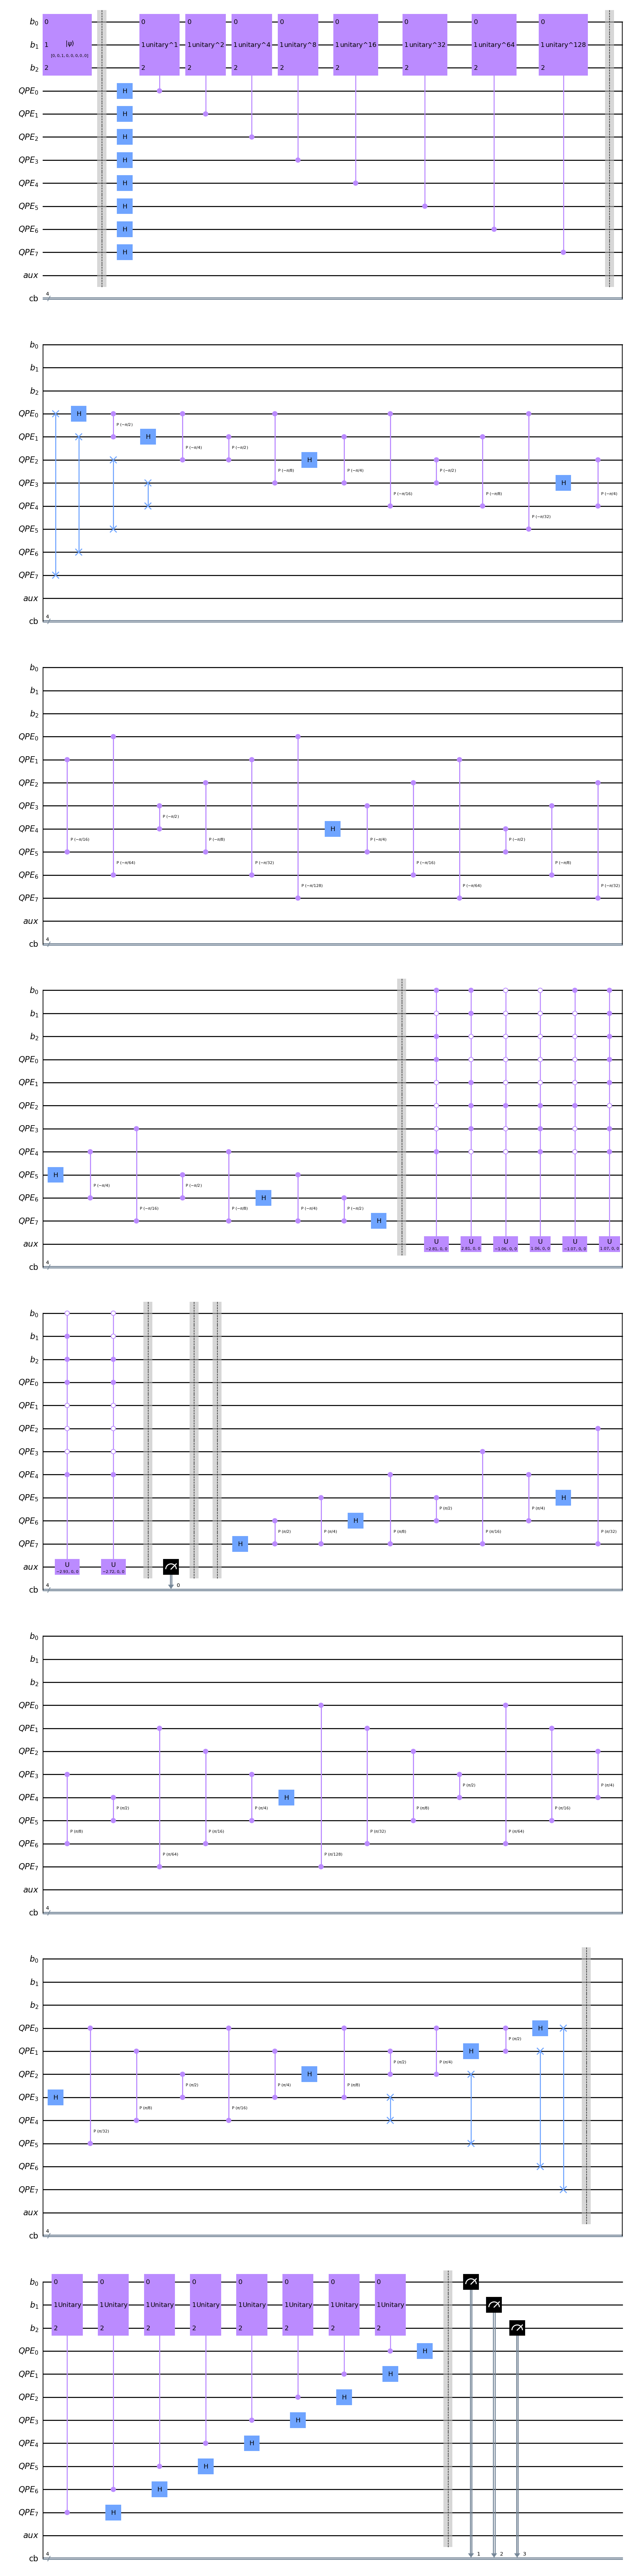

In [401]:
######################################################
############## Hyperparams + Problem #################
######################################################
tol = 2e-4 # accuracy of QPE
ev_time = 150 # evolution time t

# A is a 3x3 invertible non hermitian sparse matrix that is well scaled and stable
# A = np.array([[4/5, 1/5, 0],
#               [0, 3/5, 1/5],
#               [0, 0, 14/25]])
A = np.matrix([[1, 1, 0], [-1, 1, -1], [0, .13, 1.3]])
b = np.array([0, 0, 1])
# A = np.array([[3/4, 1/4],
#               [1/4, 3/4]])
# b = np.array([0, 1])

######################################################
################## HHL Execution #####################
######################################################

A, b, hhl = hhl_circuit(A, b, tol, ev_time)
hhl.draw('mpl')

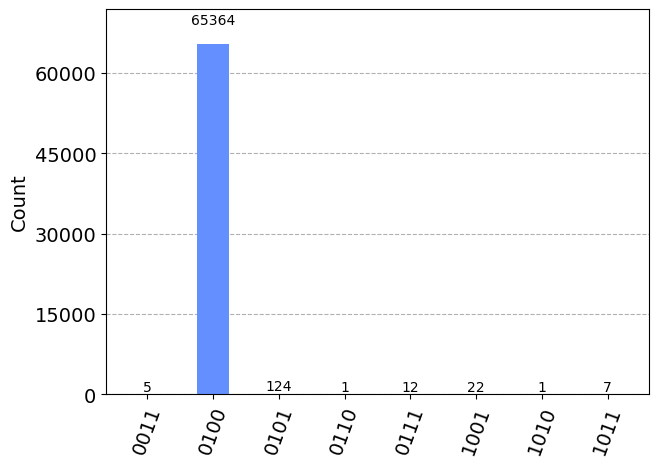

In [331]:
job = execute(hhl, backend=backend_qasm, shots=2**16)
counts = job.result().get_counts()
plot_histogram(counts)


<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 4: Subroutines

</div>

In [8]:
# implementation of subroutines